🔢 Importación y carga inicial

Distribución de clases (0 = no fraude, 1 = fraude):
is_fraud
0    1842743
1       9651
Name: count, dtype: int64

Porcentaje de cada clase:
is_fraud
0    99.48
1     0.52
Name: proportion, dtype: float64


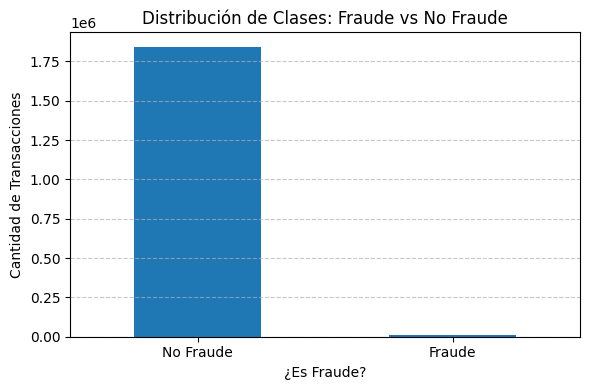

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el CSV
df = pd.read_csv('data.csv')  # Cambia por el nombre de tu archivo real

df['is_fraud'] = df['is_fraud'].astype(int)

# Conteo de clases
class_counts = df['is_fraud'].value_counts()
print("Distribución de clases (0 = no fraude, 1 = fraude):")
print(class_counts)

# Porcentaje
class_percent = df['is_fraud'].value_counts(normalize=True) * 100
print("\nPorcentaje de cada clase:")
print(class_percent.round(2))

# Visualización
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar')
plt.title("Distribución de Clases: Fraude vs No Fraude")
plt.xlabel("¿Es Fraude?")
plt.ylabel("Cantidad de Transacciones")
plt.xticks(ticks=[0,1], labels=["No Fraude", "Fraude"], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


📊 Variables agregadas por usuario

In [3]:
# Transacciones por usuario
df['transacciones_por_usuario'] = df.groupby('cc_num')['cc_num'].transform('count')

# Monto total gastado por usuario
df['monto_total_usuario'] = df.groupby('cc_num')['amt'].transform('sum')

# Promedio de gasto por usuario
df['monto_promedio_usuario'] = df['monto_total_usuario'] / df['transacciones_por_usuario']

# quincena
df['quincena'] = df['trans_day'].apply(lambda d: 'quincena_1' if d <= 15 else 'quincena_2')


#compras lejanas
df["is_international_guess"] = df["dist_between_client_and_merch"] > 1000


# Compra de noche #horas de la noche
df['es_noche'] = df['hour'].apply(lambda x: 1 if x < 6 or x > 22 else 0)

# Distancia sospechosa
df['distancia_muy_lejana'] = (df['dist_between_client_and_merch'] > 100).astype(int)




In [ ]:
#distancia entre estados no distancia quemada de cliente si no un promedio o un radio 
import pandas as pd
import numpy as np


# distancia Haversine (distancia entre cliente y comercio)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# distancia puntual cliente-comercio
if 'dist_between_client_and_merch' not in df.columns:
    df['dist_between_client_and_merch'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

# estado cliente = estado comercio si no hay merch_state en el datset
df['merch_state'] = df['state']

# Calcular la distancia promedio
df['distancia'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])
promedios_estado = df.groupby(['state', 'merch_state'])['distancia'].mean().reset_index()
promedios_estado.columns = ['state', 'merch_state', 'distancia_estado_promedio']

# Unir el promedio al df original
df = df.merge(promedios_estado, on=['state', 'merch_state'], how='left')

# Crear variable binaria de distancia sospechosa
umbral = df['distancia_estado_promedio'].median()
df['distancia_estado_sospechosa'] = (df['distancia_estado_promedio'] > umbral).astype(int)

# borrar columnas intermedias
df.drop(columns=['distancia'], inplace=True)


In [6]:
categorias_riesgosas = ['misc_net', 'shopping_net', 'shopping_pos']

df['comercio_riesgoso'] = df['category'].isin(categorias_riesgosas).astype(int)


riesgo_por_categoria = df.groupby('category')['is_fraud'].mean().sort_values(ascending=False)
print(riesgo_por_categoria)


category
shopping_net      0.015927
misc_net          0.013039
grocery_pos       0.012645
shopping_pos      0.006344
gas_transport     0.004106
misc_pos          0.002819
grocery_net       0.002697
travel            0.002692
personal_care     0.002229
entertainment     0.002177
kids_pets         0.001880
food_dining       0.001568
home              0.001510
health_fitness    0.001510
Name: is_fraud, dtype: float64


💰 Alto riesgo

In [ ]:
umbral_alto = df['amt'].quantile(0.90) 

df['transaccion_alto_riesgo'] = ((df['amt'] > umbral_alto) & (df['comercio_riesgoso'] == 1)).astype(int)


🤖 Modelo

In [22]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score, recall_score, precision_score

# Selección de features (puedes ajustar esta lista si agregaste más variables)
features = [
    'amt', 'amt_month', 'amt_year',
    'first_time_at_merchant', 'count_month_shopping_net',
    'dist_between_client_and_merch', 'distancia_estado_sospechosa'
]

# Preparación de datos
X = df[features]
y = df['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Entrenamiento con parámetros ajustados
model = LGBMClassifier(
    random_state=42,
    class_weight='balanced',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    num_leaves=31
)
model.fit(X_train, y_train)

# Probabilidades y predicción estándar
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.5).astype(int)  # Podemos ajustar este umbral más adelante


[LightGBM] [Info] Number of positive: 7238, number of negative: 1382057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 1389295, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [23]:
print("Evaluación con diferentes umbrales:")
for threshold in [0.3, 0.4, 0.5, 0.6]:
    y_pred_thr = (y_proba > threshold).astype(int)
    prec = precision_score(y_test, y_pred_thr)
    rec = recall_score(y_test, y_pred_thr)
    f1 = f1_score(y_test, y_pred_thr)
    print(f"Umbral: {threshold:.2f} → Precisión: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")


Evaluación con diferentes umbrales:
Umbral: 0.30 → Precisión: 0.036, Recall: 0.951, F1: 0.070
Umbral: 0.40 → Precisión: 0.049, Recall: 0.928, F1: 0.093
Umbral: 0.50 → Precisión: 0.065, Recall: 0.904, F1: 0.122
Umbral: 0.60 → Precisión: 0.087, Recall: 0.878, F1: 0.158


In [24]:
# Evaluación específica en transacciones de alto riesgo
alto_riesgo_idx = X_test[df.loc[X_test.index, 'transaccion_alto_riesgo'] == 1].index
y_pred_riesgo = model.predict(X_test.loc[alto_riesgo_idx])

recall_alto_riesgo = recall_score(y_test.loc[alto_riesgo_idx], y_pred_riesgo)
precision_alto_riesgo = precision_score(y_test.loc[alto_riesgo_idx], y_pred_riesgo)

print(f"\n🛑 Recall en transacciones de alto riesgo: {recall_alto_riesgo:.3f}")
print(f"🎯 Precisión en transacciones de alto riesgo: {precision_alto_riesgo:.3f}")



🛑 Recall en transacciones de alto riesgo: 0.998
🎯 Precisión en transacciones de alto riesgo: 0.163
